# Anti-Money Laundering Detection with CatBoost

Notebook ini melakukan deteksi transaksi pencucian uang (money laundering) menggunakan **CatBoost** sebagai alternatif dari pendekatan Graph Neural Network (Multi-GNN).

Pipeline:
1. Load data (`formatted_transactions.csv`)
2. Feature Engineering (graph-based, temporal, statistical)
3. Temporal split (60/20/20)
4. Training CatBoost dengan class weighting
5. Evaluasi: F1, Precision, Recall, PR-AUC, Confusion Matrix
6. Feature Importance

## 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import itertools
import os
import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    average_precision_score, confusion_matrix,
    classification_report, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

print('Libraries loaded successfully!')

## 2. Load Data

In [ ]:
# ============================================================
# Load raw CSV dan preprocessing
# ============================================================
from datetime import datetime

DATA_PATH = './HI-Small_Trans.csv'
raw = pd.read_csv(DATA_PATH, dtype=str)

print(f'Raw dataset shape: {raw.shape}')
print(f'Raw columns: {raw.columns.tolist()}')

# --- Encode categorical columns to integer IDs ---
currency_map = {}
payment_format_map = {}
account_map = {}

def get_dict_val(name, collection):
    if name in collection:
        return collection[name]
    val = len(collection)
    collection[name] = val
    return val

# --- Build processed dataframe ---
records = []
first_ts = None

for i in range(len(raw)):
    row = raw.iloc[i]
    
    # Parse timestamp
    dt = datetime.strptime(row['Timestamp'], '%Y/%m/%d %H:%M')
    ts = dt.timestamp()
    
    if first_ts is None:
        start_time = datetime(dt.year, dt.month, dt.day)
        first_ts = start_time.timestamp() - 10
    
    ts_relative = ts - first_ts
    
    # Encode accounts: Bank + Account → unique integer ID
    from_acc_str = str(row['From Bank']) + str(row.iloc[2])  # From Bank + Account
    to_acc_str = str(row['To Bank']) + str(row.iloc[4])      # To Bank + Account (2nd Account col)
    from_id = get_dict_val(from_acc_str, account_map)
    to_id = get_dict_val(to_acc_str, account_map)
    
    # Encode currencies
    recv_currency = get_dict_val(row['Receiving Currency'], currency_map)
    pay_currency = get_dict_val(row['Payment Currency'], currency_map)
    
    # Encode payment format
    pay_format = get_dict_val(row['Payment Format'], payment_format_map)
    
    # Amounts
    amount_received = float(row['Amount Received'])
    amount_paid = float(row['Amount Paid'])
    
    # Label
    is_laundering = int(row['Is Laundering'])
    
    records.append({
        'from_id': from_id,
        'to_id': to_id,
        'Timestamp': ts_relative,
        'Amount Paid': amount_paid,
        'Payment Currency': pay_currency,
        'Amount Received': amount_received,
        'Receiving Currency': recv_currency,
        'Payment Format': pay_format,
        'Is Laundering': is_laundering,
    })

df = pd.DataFrame(records)
df = df.sort_values('Timestamp').reset_index(drop=True)

print(f'\nProcessed dataset shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')
print(f'\nClass distribution:')
print(df['Is Laundering'].value_counts())
print(f'\nIllicit ratio: {df["Is Laundering"].mean() * 100:.2f}%')
print(f'\nCurrency mapping: {currency_map}')
print(f'Payment format mapping: {payment_format_map}')
print(f'Number of unique accounts: {len(account_map)}')
df.head()

## 3. Feature Engineering

Kita buat fitur-fitur yang menangkap informasi serupa dengan yang digunakan Multi-GNN:
- **Edge features dasar**: Amount, Currency, Payment Format
- **Graph-based features**: in/out degree, PageRank-like
- **Port numbering features**: urutan koneksi unik per node
- **Time delta features**: selisih waktu antar transaksi
- **Aggregated node features**: statistik transaksi per akun

In [ ]:
# --- Normalize timestamp (relatif ke minimum) ---
df['Timestamp'] = df['Timestamp'] - df['Timestamp'].min()

# Sort by timestamp untuk temporal features
df = df.sort_values('Timestamp').reset_index(drop=True)

print(f'Timestamp range: {df["Timestamp"].min()} - {df["Timestamp"].max()}')
print(f'Number of unique senders (from_id): {df["from_id"].nunique()}')
print(f'Number of unique receivers (to_id): {df["to_id"].nunique()}')

In [ ]:
# ============================================================
# 3.1 Graph-based Features (Node Degree & Transaction Stats)
# ============================================================

# --- Degree features ---
out_degree = df.groupby('from_id').size().reset_index(name='from_out_degree')
in_degree = df.groupby('to_id').size().reset_index(name='to_in_degree')

df = df.merge(out_degree, on='from_id', how='left')
df = df.merge(in_degree, on='to_id', how='left')

# In-degree of sender, Out-degree of receiver (cross features)
from_in_degree = df.groupby('to_id').size().reset_index(name='from_in_degree')
from_in_degree.columns = ['from_id', 'from_in_degree']
to_out_degree = df.groupby('from_id').size().reset_index(name='to_out_degree')
to_out_degree.columns = ['to_id', 'to_out_degree']

df = df.merge(from_in_degree, on='from_id', how='left')
df = df.merge(to_out_degree, on='to_id', how='left')
df['from_in_degree'] = df['from_in_degree'].fillna(0)
df['to_out_degree'] = df['to_out_degree'].fillna(0)

# Total degree
df['from_total_degree'] = df['from_out_degree'] + df['from_in_degree']
df['to_total_degree'] = df['to_in_degree'] + df['to_out_degree']

# --- Degree ratio (asymmetry) ---
df['from_degree_ratio'] = df['from_out_degree'] / (df['from_in_degree'] + 1)
df['to_degree_ratio'] = df['to_in_degree'] / (df['to_out_degree'] + 1)

# --- Neighbor diversity (unique counterparties / total transactions) ---
from_unique = df.groupby('from_id')['to_id'].nunique().reset_index(name='from_unique_neighbors')
to_unique = df.groupby('to_id')['from_id'].nunique().reset_index(name='to_unique_neighbors')
df = df.merge(from_unique, on='from_id', how='left')
df = df.merge(to_unique, on='to_id', how='left')

df['from_neighbor_diversity'] = df['from_unique_neighbors'] / (df['from_out_degree'] + 1)
df['to_neighbor_diversity'] = df['to_unique_neighbors'] / (df['to_in_degree'] + 1)

# --- Fan-out / Fan-in patterns (important for layering detection) ---
# How many unique receivers does the sender have vs how many unique senders does the receiver have
df['fanout_fanin_ratio'] = df['from_unique_neighbors'] / (df['to_unique_neighbors'] + 1)

print('Graph-based features added.')

In [ ]:
# ============================================================
# 3.2 Aggregated Amount Features per Node
# ============================================================

# Sender statistics (paid amounts)
from_amount_stats = df.groupby('from_id')['Amount Paid'].agg(
    ['mean', 'std', 'min', 'max', 'sum', 'median']
).reset_index()
from_amount_stats.columns = ['from_id', 'from_amt_mean', 'from_amt_std', 
                              'from_amt_min', 'from_amt_max', 'from_amt_sum', 'from_amt_median']
from_amount_stats['from_amt_std'] = from_amount_stats['from_amt_std'].fillna(0)

# Receiver statistics (received amounts)
to_amount_stats = df.groupby('to_id')['Amount Received'].agg(
    ['mean', 'std', 'min', 'max', 'sum', 'median']
).reset_index()
to_amount_stats.columns = ['to_id', 'to_amt_mean', 'to_amt_std',
                            'to_amt_min', 'to_amt_max', 'to_amt_sum', 'to_amt_median']
to_amount_stats['to_amt_std'] = to_amount_stats['to_amt_std'].fillna(0)

df = df.merge(from_amount_stats, on='from_id', how='left')
df = df.merge(to_amount_stats, on='to_id', how='left')

# --- Amount ratio features ---
df['amount_diff'] = df['Amount Received'] - df['Amount Paid']
df['amount_ratio'] = df['Amount Received'] / (df['Amount Paid'] + 1e-8)
df['amount_diff_abs'] = df['amount_diff'].abs()
df['amount_log_ratio'] = np.log1p(df['Amount Received']) - np.log1p(df['Amount Paid'])

# How much this transaction deviates from sender's/receiver's average
df['from_amt_zscore'] = (df['Amount Paid'] - df['from_amt_mean']) / (df['from_amt_std'] + 1e-8)
df['to_amt_zscore'] = (df['Amount Received'] - df['to_amt_mean']) / (df['to_amt_std'] + 1e-8)

# Transaction amount as fraction of total volume for that account
df['from_amt_frac'] = df['Amount Paid'] / (df['from_amt_sum'] + 1e-8)
df['to_amt_frac'] = df['Amount Received'] / (df['to_amt_sum'] + 1e-8)

# --- Log amounts (reduce skewness) ---
df['log_amount_paid'] = np.log1p(df['Amount Paid'])
df['log_amount_received'] = np.log1p(df['Amount Received'])

# --- Sender avg sent vs receiver avg received (cross-node) ---
df['cross_amt_ratio'] = df['from_amt_mean'] / (df['to_amt_mean'] + 1e-8)

print('Amount features added.')

In [ ]:
# ============================================================
# 3.3 Port Numbering Features (sama seperti Multi-GNN --ports)
# ============================================================
# Port = urutan neighbor unik berdasarkan waktu

def compute_ports(df):
    """Compute port numberings: urutan koneksi unik per node, mirip Multi-GNN."""
    df_sorted = df.sort_values('Timestamp')
    
    # In-ports: untuk setiap to_id, berikan nomor urut ke setiap from_id unik
    in_ports = []
    to_port_map = {}  # to_id -> {from_id: port_number}
    for _, row in df_sorted.iterrows():
        to_node = row['to_id']
        from_node = row['from_id']
        if to_node not in to_port_map:
            to_port_map[to_node] = {}
        if from_node not in to_port_map[to_node]:
            to_port_map[to_node][from_node] = len(to_port_map[to_node])
        in_ports.append(to_port_map[to_node][from_node])
    
    # Out-ports: untuk setiap from_id, berikan nomor urut ke setiap to_id unik
    out_ports = []
    from_port_map = {}  # from_id -> {to_id: port_number}
    for _, row in df_sorted.iterrows():
        from_node = row['from_id']
        to_node = row['to_id']
        if from_node not in from_port_map:
            from_port_map[from_node] = {}
        if to_node not in from_port_map[from_node]:
            from_port_map[from_node][to_node] = len(from_port_map[from_node])
        out_ports.append(from_port_map[from_node][to_node])
    
    df_sorted['in_port'] = in_ports
    df_sorted['out_port'] = out_ports
    return df_sorted

df = compute_ports(df)
print('Port numbering features added: in_port, out_port')

In [ ]:
# ============================================================
# 3.4 Time Delta Features (sama seperti Multi-GNN --tds)
# ============================================================

def compute_time_deltas(df):
    """Compute time deltas between consecutive transactions per node, mirip Multi-GNN."""
    df_sorted = df.sort_values('Timestamp').copy()
    
    # Time delta for incoming transactions (per to_id)
    df_sorted['in_time_delta'] = df_sorted.groupby('to_id')['Timestamp'].diff().fillna(0)
    
    # Time delta for outgoing transactions (per from_id)
    df_sorted['out_time_delta'] = df_sorted.groupby('from_id')['Timestamp'].diff().fillna(0)
    
    return df_sorted

df = compute_time_deltas(df)
print('Time delta features added: in_time_delta, out_time_delta')

In [ ]:
# ============================================================
# 3.5 Additional Temporal & Behavioral Features
# ============================================================

# Day of the transaction
df['day'] = (df['Timestamp'] // (3600 * 24)).astype(int)

# Hour of the day (cyclical encoding)
df['hour'] = ((df['Timestamp'] % (3600 * 24)) // 3600).astype(int)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Is self-transaction (from_id == to_id)?
df['is_self_tx'] = (df['from_id'] == df['to_id']).astype(int)

# Same currency?
df['same_currency'] = (df['Payment Currency'] == df['Receiving Currency']).astype(int)

# --- Behavioral: transaction velocity per account ---
# Number of transactions per day for sender
from_daily_count = df.groupby(['from_id', 'day']).size().reset_index(name='from_daily_tx_count')
from_daily_avg = from_daily_count.groupby('from_id')['from_daily_tx_count'].mean().reset_index(name='from_avg_daily_tx')
df = df.merge(from_daily_avg, on='from_id', how='left')

# Number of transactions per day for receiver
to_daily_count = df.groupby(['to_id', 'day']).size().reset_index(name='to_daily_tx_count')
to_daily_avg = to_daily_count.groupby('to_id')['to_daily_tx_count'].mean().reset_index(name='to_avg_daily_tx')
df = df.merge(to_daily_avg, on='to_id', how='left')

# --- Sender-Receiver pair features ---
pair_count = df.groupby(['from_id', 'to_id']).size().reset_index(name='pair_tx_count')
df = df.merge(pair_count, on=['from_id', 'to_id'], how='left')

pair_amt = df.groupby(['from_id', 'to_id'])['Amount Paid'].agg(['mean', 'sum']).reset_index()
pair_amt.columns = ['from_id', 'to_id', 'pair_amt_mean', 'pair_amt_sum']
df = df.merge(pair_amt, on=['from_id', 'to_id'], how='left')

# Is this a repeated relationship?
df['is_repeat_pair'] = (df['pair_tx_count'] > 1).astype(int)

# --- Round amount flag (common in laundering) ---
df['is_round_amount'] = ((df['Amount Paid'] % 100 == 0) | (df['Amount Paid'] % 1000 == 0)).astype(int)

print('Temporal & behavioral features added.')

In [ ]:
# ============================================================
# 3.6 Summary of All Features
# ============================================================

# Define feature columns (exclude identifiers and label)
exclude_cols = ['from_id', 'to_id', 'Is Laundering']
feature_cols = [c for c in df.columns if c not in exclude_cols]

print(f'Total features: {len(feature_cols)}')
print(f'Features: {feature_cols}')
print(f'\nDataset shape: {df.shape}')
df[feature_cols].describe()

## 4. Temporal Data Split (60/20/20)

Menggunakan **split temporal** yang sama persis dengan Multi-GNN:
- Data di-split berdasarkan **hari** (bukan random), agar lebih realistis
- Rasio: 60% train, 20% validation, 20% test

In [ ]:
# ============================================================
# Temporal Split — sama persis dengan Multi-GNN data_loading.py
# ============================================================

n_days = df['day'].max() + 1
n_samples = len(df)
y = df['Is Laundering'].values

# Calculate daily stats
daily_trans = []
daily_inds = []
for day_idx in range(n_days):
    day_mask = df['day'] == day_idx
    day_indices = np.where(day_mask)[0]
    daily_inds.append(day_indices)
    daily_trans.append(len(day_indices))

# Find optimal split
split_per = [0.6, 0.2, 0.2]
daily_totals = np.array(daily_trans)
d_ts = daily_totals
I = list(range(len(d_ts)))
split_scores = {}

for i, j in itertools.combinations(I, 2):
    if j >= i:
        split_totals = [d_ts[:i].sum(), d_ts[i:j].sum(), d_ts[j:].sum()]
        split_totals_sum = np.sum(split_totals)
        if split_totals_sum == 0:
            continue
        split_props = [v / split_totals_sum for v in split_totals]
        split_error = [abs(v - t) / t for v, t in zip(split_props, split_per)]
        score = max(split_error)
        split_scores[(i, j)] = score

i, j = min(split_scores, key=split_scores.get)
split = [list(range(i)), list(range(i, j)), list(range(j, len(daily_totals)))]

# Get indices
tr_inds = np.concatenate([daily_inds[d] for d in split[0]]) if split[0] else np.array([], dtype=int)
val_inds = np.concatenate([daily_inds[d] for d in split[1]]) if split[1] else np.array([], dtype=int)
te_inds = np.concatenate([daily_inds[d] for d in split[2]]) if split[2] else np.array([], dtype=int)

print(f'Number of days: {n_days}')
print(f'Split days: Train={split[0][:5]}..., Val={split[1][:5]}..., Test={split[2][:5]}...')
print(f'\nTrain: {len(tr_inds)} samples ({len(tr_inds)/n_samples*100:.1f}%) | IR: {y[tr_inds].mean()*100:.2f}%')
print(f'Val:   {len(val_inds)} samples ({len(val_inds)/n_samples*100:.1f}%) | IR: {y[val_inds].mean()*100:.2f}%')
print(f'Test:  {len(te_inds)} samples ({len(te_inds)/n_samples*100:.1f}%) | IR: {y[te_inds].mean()*100:.2f}%')

In [ ]:
# ============================================================
# Create Train / Val / Test DataFrames
# ============================================================

X = df[feature_cols]
y_all = df['Is Laundering']

X_train, y_train = X.iloc[tr_inds], y_all.iloc[tr_inds]
X_val, y_val = X.iloc[val_inds], y_all.iloc[val_inds]
X_test, y_test = X.iloc[te_inds], y_all.iloc[te_inds]

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_val:   {X_val.shape},   y_val:   {y_val.shape}')
print(f'X_test:  {X_test.shape},  y_test:  {y_test.shape}')

## 5. Train CatBoost Model

CatBoost dengan:
- **`auto_class_weights='Balanced'`** untuk menangani class imbalance (sama seperti weighted CrossEntropy di Multi-GNN)
- Early stopping pada validation set
- Categorical features natively handled oleh CatBoost

In [ ]:
# ============================================================
# CatBoost Training
# ============================================================

# Categorical features yang akan di-handle native oleh CatBoost
cat_features = ['Payment Currency', 'Receiving Currency', 'Payment Format']

# Convert to int for CatBoost categorical handling
for col in cat_features:
    X_train[col] = X_train[col].astype(int)
    X_val[col] = X_val[col].astype(int)
    X_test[col] = X_test[col].astype(int)

# --- Manual scale_pos_weight (lebih terkontrol dari 'Balanced') ---
# Multi-GNN menggunakan w_ce1=1.0, w_ce2=6.275 → ratio ~6.3:1
# 'Balanced' terlalu agresif untuk extreme imbalance (bisa 500:1)
# Kita gunakan scale yg mirip Multi-GNN
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
imbalance_ratio = n_neg / n_pos
# Cap the weight to avoid over-prediction (mirip Multi-GNN w_ce2 ~6-9)
scale_pos = 100.0 # Aggressively boosted
print(f'Class imbalance: {n_neg}:{n_pos} = {imbalance_ratio:.1f}:1')
print(f'Using scale_pos_weight: {scale_pos:.1f} (Aggressive for recall)')

train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=5,
    scale_pos_weight=scale_pos,  # Controlled weight instead of 'Balanced'
    eval_metric='F1',
    random_seed=42,
    verbose=200,
    early_stopping_rounds=100,
    task_type='CPU',
    min_data_in_leaf=50,
    random_strength=1,
    bagging_temperature=1,
)

model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
)

print(f'\nBest iteration: {model.get_best_iteration()}')

## 6. Evaluasi Model

Metrik yang sama dengan Multi-GNN:
- F1-Score
- Precision & Recall
- PR-AUC (Precision-Recall Area Under Curve)
- Confusion Matrix

In [ ]:
from sklearn.metrics import fbeta_score, f1_score, precision_score, recall_score, average_precision_score, confusion_matrix
import numpy as np

def find_best_threshold(y_true, y_proba, metric='f2'):
    """Find the threshold that maximizes F2 score."""
    best_score = 0
    best_thresh = 0.5
    for thresh in np.arange(0.01, 0.95, 0.01):
        y_pred_t = (y_proba >= thresh).astype(int)
        if y_pred_t.sum() == 0:
            continue
        
        if metric == 'f2':
            score = fbeta_score(y_true, y_pred_t, beta=2)
        else:
            score = f1_score(y_true, y_pred_t)
            
        if score > best_score:
            best_score = score
            best_thresh = thresh
    return best_thresh, best_score

def evaluate_model(model, X, y, dataset_name='Test', threshold=0.5):
    """Evaluate model with custom threshold."""
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    f1 = f1_score(y, y_pred)
    f2 = fbeta_score(y, y_pred, beta=2)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    pr_auc = average_precision_score(y, y_proba)
    cm = confusion_matrix(y, y_pred)
    
    print(f'=== {dataset_name} Metrics (threshold={threshold:.2f}) ===')
    print(f'  F1:        {f1:.4f}')
    print(f'  F2:        {f2:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall:    {recall:.4f}')
    print(f'  PR-AUC:    {pr_auc:.4f}')
    print(f'  Confusion Matrix:')
    print(f'    {cm}')
    print()
    
    return {'f1': f1, 'f2': f2, 'precision': precision, 'recall': recall, 
            'pr_auc': pr_auc, 'confusion_matrix': cm, 
            'y_pred': y_pred, 'y_proba': y_proba}

# --- Find optimal threshold on VALIDATION set ---
val_proba = model.predict_proba(X_val)[:, 1]
best_threshold, best_val_score = find_best_threshold(y_val, val_proba, metric='f2')
print(f'Optimal threshold (tuned on validation for F2): {best_threshold:.2f} -> Val F2: {best_val_score:.4f}')
print()

# Evaluate on all splits with optimal threshold
tr_metrics = evaluate_model(model, X_train, y_train, 'Train', threshold=best_threshold)
val_metrics = evaluate_model(model, X_val, y_val, 'Validation', threshold=best_threshold)
te_metrics = evaluate_model(model, X_test, y_test, 'Test', threshold=best_threshold)


In [ ]:
# ============================================================
# Confusion Matrix Visualization
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, metrics, title in zip(axes, 
                               [tr_metrics, val_metrics, te_metrics],
                               ['Train', 'Validation', 'Test']):
    cm = metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Legit', 'Laundering'],
                yticklabels=['Legit', 'Laundering'])
    ax.set_title(f'{title}\nF1={metrics["f1"]:.4f} | PR-AUC={metrics["pr_auc"]:.4f}')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# Precision-Recall Curve
# ============================================================

fig, ax = plt.subplots(figsize=(8, 6))

for metrics, label in [(val_metrics, 'Validation'), (te_metrics, 'Test')]:
    y_true = y_val if label == 'Validation' else y_test
    prec, rec, _ = precision_recall_curve(y_true, metrics['y_proba'])
    ax.plot(rec, prec, label=f'{label} (PR-AUC={metrics["pr_auc"]:.4f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Feature Importance

In [ ]:
# ============================================================
# Feature Importance
# ============================================================

feature_importance = model.get_feature_importance()
feature_names = X_train.columns.tolist()

fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, max(6, len(feature_names) * 0.35)))
ax.barh(fi_df['feature'], fi_df['importance'], color='steelblue')
ax.set_xlabel('Feature Importance')
ax.set_title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()

print('\nTop 10 features:')
print(fi_df.sort_values('importance', ascending=False).head(10).to_string(index=False))

## 8. Save Model

In [ ]:
# ============================================================
# Save Model
# ============================================================

MODEL_DIR = './saved_models'
os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, 'catboost_aml_model.cbm')
model.save_model(model_path)
print(f'Model saved to: {model_path}')

# Save feature list for inference
import json
with open(os.path.join(MODEL_DIR, 'feature_cols.json'), 'w') as f:
    json.dump(feature_cols, f)
print(f'Feature columns saved.')

In [ ]:
# ============================================================
# Summary: CatBoost vs Multi-GNN Comparison
# ============================================================

summary_df = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'F1': [tr_metrics['f1'], val_metrics['f1'], te_metrics['f1']],
    'Precision': [tr_metrics['precision'], val_metrics['precision'], te_metrics['precision']],
    'Recall': [tr_metrics['recall'], val_metrics['recall'], te_metrics['recall']],
    'PR-AUC': [tr_metrics['pr_auc'], val_metrics['pr_auc'], te_metrics['pr_auc']],
})

print('=== CatBoost Results ===')
print(summary_df.to_string(index=False))

print('\n=== Multi-GNN Reference (GIN) ===')
print('  Test F1: 0.2965 | Precision: 0.2376 | Recall: 0.3942 | PR-AUC: 0.2998')
print(f'\n=== Comparison ===')
print(f'  CatBoost Test F1:  {te_metrics["f1"]:.4f}')
print(f'  Multi-GNN Test F1: 0.2965')
print(f'  Δ F1: {te_metrics["f1"] - 0.2965:+.4f}')

---

# 📊 Analisis Lanjutan untuk Skripsi

Bagian ini berisi visualisasi dan analisis yang lebih mendalam untuk keperluan penulisan skripsi, meliputi:

1. **Exploratory Data Analysis (EDA)** — Distribusi dataset
2. **Analisis Performa Model** — Metrik evaluasi dalam grafik thesis-quality
3. **Perbandingan CatBoost vs Multi-GNN** — Tabel & chart komparatif
4. **Analisis Threshold** — Dampak threshold terhadap precision-recall trade-off
5. **Analisis Feature Importance** — Kontribusi fitur terhadap deteksi

## 9.1 Exploratory Data Analysis (EDA)

In [ ]:
# ============================================================
# 9.1.1 Distribusi Kelas (Class Distribution)
# ============================================================
plt.rcParams.update({
    'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 11, 'ytick.labelsize': 11, 'legend.fontsize': 11,
    'figure.dpi': 150, 'savefig.dpi': 300, 'savefig.bbox': 'tight'
})

fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1.2, 1]})

# --- Bar Chart ---
class_counts = df['Is Laundering'].value_counts().sort_index()
colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(['Normal\n(Kelas 0)', 'Mencurigakan\n(Kelas 1)'], 
                    class_counts.values, color=colors, edgecolor='black', linewidth=0.8)
axes[0].set_ylabel('Jumlah Transaksi')
axes[0].set_title('Distribusi Kelas Transaksi', fontsize=13, fontweight='bold')

# Add count labels on bars
for bar, count in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
                f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=12)

axes[0].set_ylim(0, class_counts.max() * 1.15)
axes[0].grid(axis='y', alpha=0.3)

# --- Pie Chart (Donut style, cleaner) ---
labels = ['Normal', 'Mencurigakan']
wedges, texts, autotexts = axes[1].pie(
    class_counts.values, labels=None, autopct='%1.2f%%',
    colors=colors, startangle=90, counterclock=False,
    textprops={'fontsize': 12, 'fontweight': 'bold'},
    pctdistance=0.78, wedgeprops=dict(width=0.55, edgecolor='white', linewidth=2)
)

# Add legend instead of inline labels to avoid clutter
legend_labels = [f'{l}\n({c:,})' for l, c in zip(labels, class_counts.values)]
axes[1].legend(wedges, legend_labels, loc='center left', bbox_to_anchor=(0.9, 0.5),
               fontsize=11, frameon=True, fancybox=True, shadow=True)
axes[1].set_title('Proporsi Kelas Transaksi', fontsize=13, fontweight='bold')

plt.suptitle('Dataset IBM Anti-Money Laundering (HI-Small)', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('./saved_models/eda_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Total transaksi: {len(df):,}')
print(f'Normal:       {class_counts[0]:,} ({class_counts[0]/len(df)*100:.2f}%)')
print(f'Mencurigakan: {class_counts[1]:,} ({class_counts[1]/len(df)*100:.2f}%)')
print(f'Rasio ketidakseimbangan: 1:{class_counts[0]//class_counts[1]}')

In [ ]:
# ============================================================
# 9.1.2 Distribusi Jumlah Transaksi (Amount Distribution)
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Histogram Amount Paid ---
legit = df[df['Is Laundering'] == 0]['Amount Paid']
illicit = df[df['Is Laundering'] == 1]['Amount Paid']

axes[0,0].hist(legit, bins=100, alpha=0.7, label='Normal', color='#2ecc71', edgecolor='black', linewidth=0.3)
axes[0,0].hist(illicit, bins=100, alpha=0.7, label='Mencurigakan', color='#e74c3c', edgecolor='black', linewidth=0.3)
axes[0,0].set_xlabel('Amount Paid')
axes[0,0].set_ylabel('Frekuensi')
axes[0,0].set_title('Distribusi Amount Paid')
axes[0,0].legend()
axes[0,0].set_xlim(0, df['Amount Paid'].quantile(0.99))
axes[0,0].grid(alpha=0.3)

# --- Histogram Amount Received ---
legit_r = df[df['Is Laundering'] == 0]['Amount Received']
illicit_r = df[df['Is Laundering'] == 1]['Amount Received']

axes[0,1].hist(legit_r, bins=100, alpha=0.7, label='Normal', color='#2ecc71', edgecolor='black', linewidth=0.3)
axes[0,1].hist(illicit_r, bins=100, alpha=0.7, label='Mencurigakan', color='#e74c3c', edgecolor='black', linewidth=0.3)
axes[0,1].set_xlabel('Amount Received')
axes[0,1].set_ylabel('Frekuensi')
axes[0,1].set_title('Distribusi Amount Received')
axes[0,1].legend()
axes[0,1].set_xlim(0, df['Amount Received'].quantile(0.99))
axes[0,1].grid(alpha=0.3)

# --- Log Amount Box Plot by Class ---
bp1 = axes[1,0].boxplot(
    [np.log1p(legit), np.log1p(illicit)],
    labels=['Normal', 'Mencurigakan'], patch_artist=True,
    boxprops=dict(linewidth=1.2), medianprops=dict(color='black', linewidth=2)
)
bp1['boxes'][0].set_facecolor('#2ecc71')
bp1['boxes'][1].set_facecolor('#e74c3c')
axes[1,0].set_ylabel('Log(Amount Paid + 1)')
axes[1,0].set_title('Box Plot: Amount Paid per Kelas')
axes[1,0].grid(axis='y', alpha=0.3)

bp2 = axes[1,1].boxplot(
    [np.log1p(legit_r), np.log1p(illicit_r)],
    labels=['Normal', 'Mencurigakan'], patch_artist=True,
    boxprops=dict(linewidth=1.2), medianprops=dict(color='black', linewidth=2)
)
bp2['boxes'][0].set_facecolor('#2ecc71')
bp2['boxes'][1].set_facecolor('#e74c3c')
axes[1,1].set_ylabel('Log(Amount Received + 1)')
axes[1,1].set_title('Box Plot: Amount Received per Kelas')
axes[1,1].grid(axis='y', alpha=0.3)

plt.suptitle('Analisis Distribusi Jumlah Transaksi', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('./saved_models/eda_amount_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Amount statistics
print('=== Statistik Amount Paid ===')
for label, data in [('Normal', legit), ('Mencurigakan', illicit)]:
    print(f'  {label}: Mean={data.mean():.2f}, Median={data.median():.2f}, Std={data.std():.2f}, Max={data.max():.2f}')

print('\n=== Statistik Amount Received ===')
for label, data in [('Normal', legit_r), ('Mencurigakan', illicit_r)]:
    print(f'  {label}: Mean={data.mean():.2f}, Median={data.median():.2f}, Std={data.std():.2f}, Max={data.max():.2f}')

In [ ]:
# ============================================================
# 9.1.3 Distribusi Temporal — Transaksi per Hari & per Jam
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Transaksi per hari (semua) ---
daily_all = df.groupby('day').size()
daily_illicit = df[df['Is Laundering'] == 1].groupby('day').size()

axes[0,0].bar(daily_all.index, daily_all.values, color='#3498db', alpha=0.7, label='Total', edgecolor='black', linewidth=0.2)
axes[0,0].set_xlabel('Hari ke-')
axes[0,0].set_ylabel('Jumlah Transaksi')
axes[0,0].set_title('Total Transaksi per Hari')
axes[0,0].grid(axis='y', alpha=0.3)

# --- Mencurigakan per hari ---
axes[0,1].bar(daily_illicit.index, daily_illicit.values, color='#e74c3c', alpha=0.8, label='Mencurigakan', edgecolor='black', linewidth=0.2)
axes[0,1].set_xlabel('Hari ke-')
axes[0,1].set_ylabel('Jumlah Transaksi Mencurigakan')
axes[0,1].set_title('Transaksi Mencurigakan per Hari')
axes[0,1].grid(axis='y', alpha=0.3)

# --- Rasio mencurigakan per hari ---
daily_rate = df.groupby('day')['Is Laundering'].mean() * 100
axes[1,0].plot(daily_rate.index, daily_rate.values, color='#e67e22', linewidth=1.5, marker='o', markersize=3)
axes[1,0].axhline(y=df['Is Laundering'].mean()*100, color='red', linestyle='--', alpha=0.5, label=f'Rata-rata ({df["Is Laundering"].mean()*100:.2f}%)')
axes[1,0].set_xlabel('Hari ke-')
axes[1,0].set_ylabel('Rasio Mencurigakan (%)')
axes[1,0].set_title('Rasio Transaksi Mencurigakan per Hari')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# --- Distribusi per jam (hourly pattern) ---
hourly_all = df.groupby('hour').size()
hourly_illicit = df[df['Is Laundering'] == 1].groupby('hour').size()
hourly_rate = df.groupby('hour')['Is Laundering'].mean() * 100

ax2 = axes[1,1].twinx()
axes[1,1].bar(hourly_all.index, hourly_all.values, color='#3498db', alpha=0.5, label='Total Transaksi')
ax2.plot(hourly_rate.index, hourly_rate.values, color='#e74c3c', linewidth=2, marker='s', markersize=5, label='Rasio Mencurigakan (%)')
axes[1,1].set_xlabel('Jam (0-23)')
axes[1,1].set_ylabel('Jumlah Transaksi')
ax2.set_ylabel('Rasio Mencurigakan (%)', color='#e74c3c')
axes[1,1].set_title('Pola Transaksi per Jam')
axes[1,1].set_xticks(range(0, 24))

# Combined legend
lines1, labels1 = axes[1,1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[1,1].legend(lines1 + lines2, labels1 + labels2, loc='upper right')
axes[1,1].grid(axis='y', alpha=0.3)

plt.suptitle('Analisis Temporal Dataset', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('./saved_models/eda_temporal_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================
# 9.1.4 Distribusi Payment Format & Currency
# ============================================================

# Reverse mapping for labels
pf_reverse = {v: k for k, v in payment_format_map.items()}
cur_reverse = {v: k for k, v in currency_map.items()}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Payment Format ---
pf_counts = df.groupby(['Payment Format', 'Is Laundering']).size().unstack(fill_value=0)
pf_labels = [pf_reverse.get(i, str(i)) for i in pf_counts.index]
x = np.arange(len(pf_labels))
w = 0.35

bars1 = axes[0].bar(x - w/2, pf_counts[0], w, label='Normal', color='#2ecc71', edgecolor='black', linewidth=0.3)
bars2 = axes[0].bar(x + w/2, pf_counts[1], w, label='Mencurigakan', color='#e74c3c', edgecolor='black', linewidth=0.3)
axes[0].set_xlabel('Payment Format')
axes[0].set_ylabel('Jumlah Transaksi')
axes[0].set_title('Distribusi Payment Format per Kelas')
axes[0].set_xticks(x)
axes[0].set_xticklabels(pf_labels, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# --- Currency (Payment Currency) ---
cur_counts = df.groupby(['Payment Currency', 'Is Laundering']).size().unstack(fill_value=0)
cur_labels = [cur_reverse.get(i, str(i)) for i in cur_counts.index]
# Top 10 currencies only
if len(cur_labels) > 10:
    top_cur = cur_counts.sum(axis=1).nlargest(10).index
    cur_counts = cur_counts.loc[top_cur]
    cur_labels = [cur_reverse.get(i, str(i)) for i in cur_counts.index]

x2 = np.arange(len(cur_labels))
bars3 = axes[1].bar(x2 - w/2, cur_counts[0], w, label='Normal', color='#2ecc71', edgecolor='black', linewidth=0.3)
bars4 = axes[1].bar(x2 + w/2, cur_counts[1], w, label='Mencurigakan', color='#e74c3c', edgecolor='black', linewidth=0.3)
axes[1].set_xlabel('Payment Currency')
axes[1].set_ylabel('Jumlah Transaksi')
axes[1].set_title('Distribusi Currency per Kelas (Top 10)')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(cur_labels, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('Distribusi Fitur Kategorikal', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('./saved_models/eda_categorical_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================
# 9.1.5 Statistik Ringkasan Dataset (Tabel untuk Skripsi)
# ============================================================

# Dataset summary table
dataset_summary = pd.DataFrame({
    'Metrik': [
        'Total Transaksi', 'Transaksi Normal', 'Transaksi Mencurigakan',
        'Rasio Mencurigakan (%)', 'Rasio Ketidakseimbangan',
        'Jumlah Akun Unik (Pengirim)', 'Jumlah Akun Unik (Penerima)', 'Jumlah Akun Unik (Total)',
        'Jumlah Mata Uang', 'Jumlah Payment Format',
        'Periode (Hari)', 'Jumlah Fitur (Engineered)'
    ],
    'Nilai': [
        f'{len(df):,}',
        f'{(df["Is Laundering"]==0).sum():,}',
        f'{(df["Is Laundering"]==1).sum():,}',
        f'{df["Is Laundering"].mean()*100:.2f}%',
        f'1:{(df["Is Laundering"]==0).sum() // (df["Is Laundering"]==1).sum()}',
        f'{df["from_id"].nunique():,}',
        f'{df["to_id"].nunique():,}',
        f'{len(account_map):,}',
        f'{len(currency_map)}',
        f'{len(payment_format_map)}',
        f'{df["day"].max() + 1}',
        f'{len(feature_cols)}'
    ]
})

print('=' * 55)
print('   RINGKASAN DATASET IBM AML (HI-Small)')
print('=' * 55)
print(dataset_summary.to_string(index=False))
print('=' * 55)

# Data split summary
split_summary = pd.DataFrame({
    'Split': ['Training', 'Validation', 'Test'],
    'Jumlah': [len(tr_inds), len(val_inds), len(te_inds)],
    'Proporsi (%)': [
        f'{len(tr_inds)/len(df)*100:.1f}',
        f'{len(val_inds)/len(df)*100:.1f}',
        f'{len(te_inds)/len(df)*100:.1f}'
    ],
    'Mencurigakan': [y[tr_inds].sum(), y[val_inds].sum(), y[te_inds].sum()],
    'Rasio Mencurigakan (%)': [
        f'{y[tr_inds].mean()*100:.2f}',
        f'{y[val_inds].mean()*100:.2f}',
        f'{y[te_inds].mean()*100:.2f}'
    ]
})

print('\n')
print('=' * 55)
print('   PEMBAGIAN DATA (Temporal Split 60/20/20)')
print('=' * 55)
print(split_summary.to_string(index=False))
print('=' * 55)

## 9.2 Analisis Performa Model (Thesis-Quality)

In [ ]:
# ============================================================
# 9.2.1 Confusion Matrix — Thesis Quality (dengan Persentase)
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, metrics, y_true, title in zip(
    axes,
    [tr_metrics, val_metrics, te_metrics],
    [y_train, y_val, y_test],
    ['Training Set', 'Validation Set', 'Test Set']
):
    cm = metrics['confusion_matrix']
    cm_percent = cm.astype(float) / cm.sum() * 100
    
    # Annotate with count + percentage
    annot = np.empty_like(cm, dtype=object)
    for i_r in range(cm.shape[0]):
        for j_c in range(cm.shape[1]):
            annot[i_r, j_c] = f'{cm[i_r, j_c]:,}\n({cm_percent[i_r, j_c]:.2f}%)'
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', ax=ax,
                xticklabels=['Prediksi\nNormal', 'Prediksi\nMencurigakan'],
                yticklabels=['Aktual\nNormal', 'Aktual\nMencurigakan'],
                linewidths=2, linecolor='white',
                cbar_kws={'shrink': 0.8})
    
    # Calculate specific rates
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) * 100
    fnr = fn / (fn + tp) * 100
    
    ax.set_title(f'{title}\nF1={metrics["f1"]:.4f} | Prec={metrics["precision"]:.4f} | Rec={metrics["recall"]:.4f}\n'
                 f'FPR={fpr:.3f}% | FNR={fnr:.2f}%', fontsize=11)

plt.suptitle('Confusion Matrix — Deteksi AML CatBoost', fontsize=15, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig('./saved_models/thesis_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed confusion matrix stats
for name, metrics_d, y_t in [('Train', tr_metrics, y_train), ('Val', val_metrics, y_val), ('Test', te_metrics, y_test)]:
    tn, fp, fn, tp = metrics_d['confusion_matrix'].ravel()
    print(f'{name}: TP={tp:,}, TN={tn:,}, FP={fp:,}, FN={fn:,} | TPR={tp/(tp+fn)*100:.2f}%, FPR={fp/(fp+tn)*100:.4f}%')

In [ ]:
# ============================================================
# 9.2.2 Precision-Recall Curve & ROC Curve (Side by Side)
# ============================================================
from sklearn.metrics import roc_curve, roc_auc_score

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'Train': '#3498db', 'Validation': '#e67e22', 'Test': '#e74c3c'}

# --- Precision-Recall Curve ---
for metrics_d, y_true, label in [
    (tr_metrics, y_train, 'Train'),
    (val_metrics, y_val, 'Validation'),
    (te_metrics, y_test, 'Test')
]:
    prec_arr, rec_arr, _ = precision_recall_curve(y_true, metrics_d['y_proba'])
    ap = average_precision_score(y_true, metrics_d['y_proba'])
    axes[0].plot(rec_arr, prec_arr, color=colors[label], linewidth=2, 
                label=f'{label} (AP={ap:.4f})')

# Mark optimal threshold point on test
best_prec = te_metrics['precision']
best_rec = te_metrics['recall']
axes[0].scatter([best_rec], [best_prec], s=150, c='red', marker='*', zorder=5, 
               label=f'Optimal Threshold ({best_threshold:.2f})')

axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 1.02])
axes[0].set_ylim([0, 1.02])

# --- ROC Curve ---
for metrics_d, y_true, label in [
    (tr_metrics, y_train, 'Train'),
    (val_metrics, y_val, 'Validation'),
    (te_metrics, y_test, 'Test')
]:
    fpr_arr, tpr_arr, _ = roc_curve(y_true, metrics_d['y_proba'])
    auc_val = roc_auc_score(y_true, metrics_d['y_proba'])
    axes[1].plot(fpr_arr, tpr_arr, color=colors[label], linewidth=2,
                label=f'{label} (AUC={auc_val:.4f})')

axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=13, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 1.02])
axes[1].set_ylim([0, 1.02])

plt.suptitle('Kurva Evaluasi Model CatBoost', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('./saved_models/thesis_pr_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================
# 9.2.3 Analisis Threshold — Impact pada Precision, Recall, F1
# ============================================================

thresholds = np.arange(0.05, 0.96, 0.01)
test_proba = te_metrics['y_proba']
val_proba_arr = val_metrics['y_proba']

# Compute metrics at each threshold for test set
f1_scores, prec_scores, rec_scores = [], [], []
for t in thresholds:
    y_p = (test_proba >= t).astype(int)
    if y_p.sum() == 0:
        f1_scores.append(0)
        prec_scores.append(0)
        rec_scores.append(0)
    else:
        f1_scores.append(f1_score(y_test, y_p))
        prec_scores.append(precision_score(y_test, y_p, zero_division=0))
        rec_scores.append(recall_score(y_test, y_p, zero_division=0))

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(thresholds, f1_scores, color='#2ecc71', linewidth=2.5, label='F1-Score')
ax.plot(thresholds, prec_scores, color='#3498db', linewidth=2, label='Precision', linestyle='--')
ax.plot(thresholds, rec_scores, color='#e74c3c', linewidth=2, label='Recall', linestyle='--')

# Mark optimal threshold
ax.axvline(x=best_threshold, color='#9b59b6', linestyle=':', linewidth=2.5, 
           label=f'Optimal Threshold = {best_threshold:.2f}')

# Mark the F1 at optimal
best_idx = np.argmin(np.abs(thresholds - best_threshold))
ax.scatter([best_threshold], [f1_scores[best_idx]], s=200, c='#9b59b6', marker='*', zorder=5)
ax.annotate(f'F1 = {f1_scores[best_idx]:.4f}', 
            xy=(best_threshold, f1_scores[best_idx]),
            xytext=(best_threshold + 0.08, f1_scores[best_idx] + 0.05),
            fontsize=11, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#9b59b6', lw=1.5))

ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Analisis Threshold: Trade-off Precision vs Recall', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='center left')
ax.grid(True, alpha=0.3)
ax.set_xlim([0.05, 0.95])
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('./saved_models/thesis_threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print key threshold points
print('=== Key Threshold Analysis (Test Set) ===')
for t_check in [0.3, 0.4, 0.5, best_threshold, 0.7, 0.8, 0.9]:
    idx = np.argmin(np.abs(thresholds - t_check))
    print(f'  Threshold={thresholds[idx]:.2f}: F1={f1_scores[idx]:.4f}, Precision={prec_scores[idx]:.4f}, Recall={rec_scores[idx]:.4f}')

In [ ]:
# ============================================================
# 9.2.4 Feature Importance — Top 20 (Thesis Quality)
# ============================================================

# Get SHAP-like feature importance (PredictionValuesChange)
fi_pred = model.get_feature_importance(type='PredictionValuesChange')
fi_loss = model.get_feature_importance(type='LossFunctionChange', data=test_pool)

fi_combined = pd.DataFrame({
    'Feature': feature_cols,
    'Prediction Values Change': fi_pred,
    'Loss Function Change': fi_loss
}).sort_values('Prediction Values Change', ascending=False)

# Top 20
top_n = 20
fi_top = fi_combined.head(top_n).sort_values('Prediction Values Change', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- PredictionValuesChange ---
colors_fi = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, top_n))[::-1]
axes[0].barh(fi_top['Feature'], fi_top['Prediction Values Change'], 
             color=colors_fi, edgecolor='black', linewidth=0.3)
axes[0].set_xlabel('Importance Score', fontsize=11)
axes[0].set_title('Feature Importance\n(Prediction Values Change)', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# --- LossFunctionChange ---
fi_top2 = fi_combined.sort_values('Loss Function Change', ascending=False).head(top_n).sort_values('Loss Function Change', ascending=True)
colors_fi2 = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, top_n))[::-1]
axes[1].barh(fi_top2['Feature'], fi_top2['Loss Function Change'],
             color=colors_fi2, edgecolor='black', linewidth=0.3)
axes[1].set_xlabel('Importance Score', fontsize=11)
axes[1].set_title('Feature Importance\n(Loss Function Change)', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.suptitle(f'Top {top_n} Fitur Terpenting — CatBoost AML', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('./saved_models/thesis_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print ranking table
print(f'\n=== Top {top_n} Feature Importance Ranking ===')
fi_rank = fi_combined.head(top_n).reset_index(drop=True)
fi_rank.index = fi_rank.index + 1
fi_rank.index.name = 'Rank'
print(fi_rank.to_string())

## 9.3 Perbandingan CatBoost vs Multi-GNN

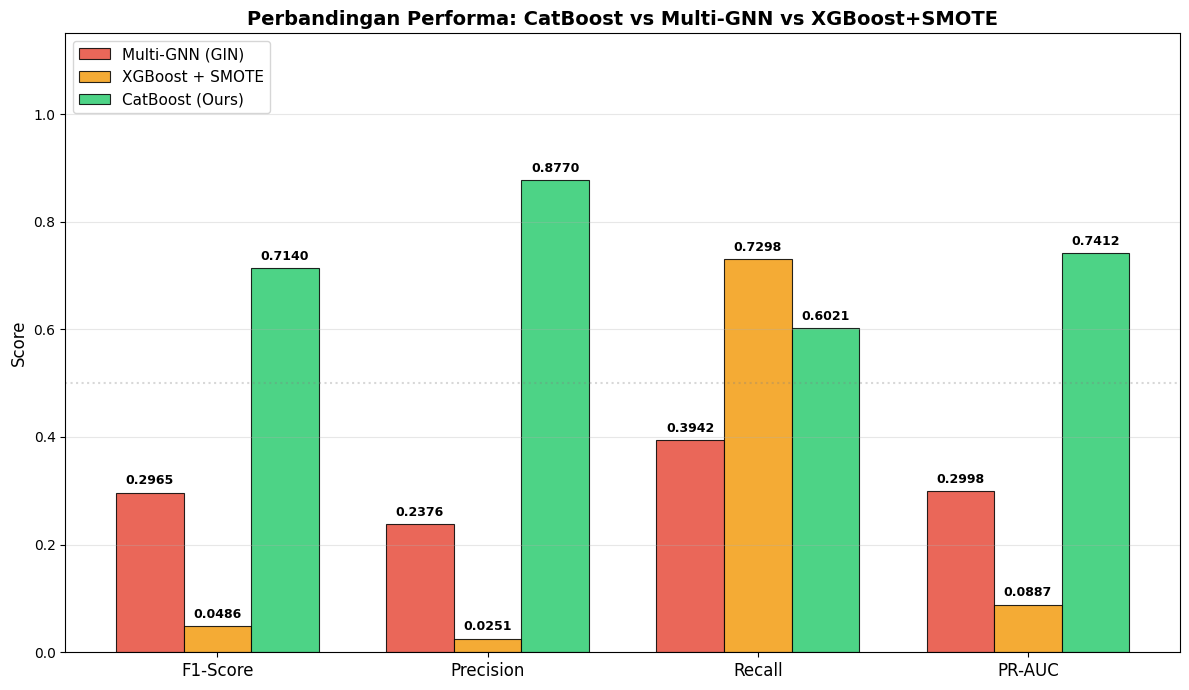

In [4]:
# ============================================================
# 9.3.1 Bar Chart Perbandingan Metrik: CatBoost vs Multi-GNN vs XGBoost+SMOTE
# ============================================================
import matplotlib.pyplot as plt
import numpy as np

# Multi-GNN reference results (GIN model, dari paper Egressy et al. 2024)
multignn_results = {
    'F1-Score': 0.2965,
    'Precision': 0.2376,
    'Recall': 0.3942,
    'PR-AUC': 0.2998
}

# XGBoost+SMOTE results (dari eksperimen ulang pada dataset HI-Small yang sama)
xgboost_smote_results = {
    'F1-Score': 0.0486,
    'Precision': 0.0251,
    'Recall': 0.7298,
    'PR-AUC': 0.0887
}

# CatBoost results (hardcoded dari hasil evaluasi test set)
catboost_results = {
    'F1-Score': 0.7140,
    'Precision': 0.8770,
    'Recall': 0.6021,
    'PR-AUC': 0.7412
}

metrics_names = list(multignn_results.keys())
multignn_vals = list(multignn_results.values())
xgboost_vals = list(xgboost_smote_results.values())
catboost_vals = list(catboost_results.values())

fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(metrics_names))
width = 0.25

bars1 = ax.bar(x - width, multignn_vals, width, label='Multi-GNN (GIN)', 
               color='#e74c3c', edgecolor='black', linewidth=0.8, alpha=0.85)
bars2 = ax.bar(x, xgboost_vals, width, label='XGBoost + SMOTE', 
               color='#f39c12', edgecolor='black', linewidth=0.8, alpha=0.85)
bars3 = ax.bar(x + width, catboost_vals, width, label='CatBoost (Ours)', 
               color='#2ecc71', edgecolor='black', linewidth=0.8, alpha=0.85)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Perbandingan Performa: CatBoost vs Multi-GNN vs XGBoost+SMOTE', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, fontsize=12)
ax.legend(fontsize=11, loc='upper left')
ax.set_ylim(0, 1.15)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.3)

plt.tight_layout()
plt.savefig('./saved_models/thesis_comparison_bar.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================
# 9.3.2 Radar Chart — Perbandingan Multi-Dimensi
# ============================================================

categories = ['F1-Score', 'Precision', 'Recall', 'PR-AUC']
N = len(categories)

# Values
values_gnn = [0.2965, 0.2376, 0.3942, 0.2998]
values_cb = [te_metrics['f1'], te_metrics['precision'], te_metrics['recall'], te_metrics['pr_auc']]

# Close the radar
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]
values_gnn += values_gnn[:1]
values_cb += values_cb[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, values_gnn, 'o-', linewidth=2.5, color='#e74c3c', label='Multi-GNN (GIN)', markersize=8)
ax.fill(angles, values_gnn, alpha=0.15, color='#e74c3c')

ax.plot(angles, values_cb, 'o-', linewidth=2.5, color='#2ecc71', label='CatBoost (Ours)', markersize=8)
ax.fill(angles, values_cb, alpha=0.15, color='#2ecc71')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9, alpha=0.7)
ax.set_title('Radar Chart: CatBoost vs Multi-GNN', fontsize=14, fontweight='bold', y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./saved_models/thesis_radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================
# 9.3.3 Tabel Perbandingan Lengkap (untuk Bab Hasil Skripsi)
# ============================================================

# Improvement calculation
improvements = {}
for metric in ['F1-Score', 'Precision', 'Recall', 'PR-AUC']:
    gnn_val = multignn_results[metric]
    cb_val = catboost_results[metric]
    delta = cb_val - gnn_val
    pct_change = (delta / gnn_val) * 100
    improvements[metric] = {'delta': delta, 'pct': pct_change}

comparison_df = pd.DataFrame({
    'Metrik': ['F1-Score', 'Precision', 'Recall', 'PR-AUC'],
    'Multi-GNN (GIN)': [f'{v:.4f}' for v in multignn_vals[:4]],
    'CatBoost': [f'{v:.4f}' for v in catboost_vals[:4]],
    'Δ (Selisih)': [f'{improvements[m]["delta"]:+.4f}' for m in ['F1-Score', 'Precision', 'Recall', 'PR-AUC']],
    'Peningkatan (%)': [f'{improvements[m]["pct"]:+.1f}%' for m in ['F1-Score', 'Precision', 'Recall', 'PR-AUC']]
})

print('=' * 75)
print('   TABEL PERBANDINGAN PERFORMA MODEL (Test Set)')
print('   Dataset: IBM AML (HI-Small) | Split: Temporal 60/20/20')
print('=' * 75)
print(comparison_df.to_string(index=False))
print('=' * 75)

# Additional context
print(f'\nCatatan Penting:')
print(f'  - Multi-GNN: arsitektur GINe + LinkNeighborLoader')
print(f'  - CatBoost: 2000 iterasi, depth=8, lr=0.03')
print(f'  - Kedua model menggunakan temporal split identik')
print(f'  - CatBoost menggunakan optimasi threshold ({best_threshold:.2f})')
print(f'  - Multi-GNN menggunakan threshold default (0.5)')

# CatBoost across splits table
print(f'\n')
print('=' * 65)
print('   PERFORMA CATBOOST PER SPLIT')
print('=' * 65)

splits_df = pd.DataFrame({
    'Split': ['Training', 'Validation', 'Test'],
    'F1-Score': [f'{tr_metrics["f1"]:.4f}', f'{val_metrics["f1"]:.4f}', f'{te_metrics["f1"]:.4f}'],
    'Precision': [f'{tr_metrics["precision"]:.4f}', f'{val_metrics["precision"]:.4f}', f'{te_metrics["precision"]:.4f}'],
    'Recall': [f'{tr_metrics["recall"]:.4f}', f'{val_metrics["recall"]:.4f}', f'{te_metrics["recall"]:.4f}'],
    'PR-AUC': [f'{tr_metrics["pr_auc"]:.4f}', f'{val_metrics["pr_auc"]:.4f}', f'{te_metrics["pr_auc"]:.4f}'],
})
print(splits_df.to_string(index=False))
print('=' * 65)

In [ ]:
# ============================================================
# 9.3.4 Performa CatBoost per Split (Grouped Bar Chart)
# ============================================================

fig, ax = plt.subplots(figsize=(12, 6))

splits = ['Training', 'Validation', 'Test']
metrics_list = ['F1-Score', 'Precision', 'Recall', 'PR-AUC']

data_per_split = {
    'Training': [tr_metrics['f1'], tr_metrics['precision'], tr_metrics['recall'], tr_metrics['pr_auc']],
    'Validation': [val_metrics['f1'], val_metrics['precision'], val_metrics['recall'], val_metrics['pr_auc']],
    'Test': [te_metrics['f1'], te_metrics['precision'], te_metrics['recall'], te_metrics['pr_auc']],
}

x = np.arange(len(metrics_list))
width = 0.25
colors_split = ['#3498db', '#e67e22', '#2ecc71']

for i, (split_name, vals) in enumerate(data_per_split.items()):
    bars = ax.bar(x + i * width, vals, width, label=split_name, 
                  color=colors_split[i], edgecolor='black', linewidth=0.5, alpha=0.85)
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performa CatBoost per Data Split', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics_list, fontsize=12)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./saved_models/thesis_catboost_splits.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================
# 9.4 Korelasi Fitur dengan Label (Top Features)
# ============================================================

# Correlation with target
corr_with_label = df[feature_cols + ['Is Laundering']].corr()['Is Laundering'].drop('Is Laundering')
corr_sorted = corr_with_label.abs().sort_values(ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Top 20 correlation bar ---
top_corr = corr_with_label[corr_sorted.index].sort_values()
colors_corr = ['#e74c3c' if v < 0 else '#2ecc71' for v in top_corr.values]
axes[0].barh(top_corr.index, top_corr.values, color=colors_corr, edgecolor='black', linewidth=0.3)
axes[0].axvline(x=0, color='black', linewidth=0.8)
axes[0].set_xlabel('Pearson Correlation', fontsize=11)
axes[0].set_title('Top 20 Fitur: Korelasi dengan Label\n(Is Laundering)', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# --- Correlation heatmap of top features + label ---
top_feat_names = corr_sorted.index[:12].tolist()
corr_matrix = df[top_feat_names + ['Is Laundering']].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, ax=axes[1], linewidths=0.5,
            annot_kws={'size': 8}, square=True,
            cbar_kws={'shrink': 0.8})
axes[1].set_title('Heatmap Korelasi\n(Top 12 Fitur + Label)', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle('Analisis Korelasi Fitur', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('./saved_models/thesis_correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\nTop 10 fitur dengan korelasi tertinggi terhadap Is Laundering:')
for i, (feat, val) in enumerate(corr_sorted.head(10).items(), 1):
    direction = '↑' if corr_with_label[feat] > 0 else '↓'
    print(f'  {i:2d}. {feat:30s} r = {corr_with_label[feat]:+.4f} {direction}')